## GSAT trend patterns

In [1]:
# In[1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# %%
# define function
import src.SAT_function as data_process
import src.Data_Preprocess as preprocess

In [2]:
# import src.slurm_cluster as scluster
# client, scluster = scluster.init_dask_slurm_cluster()

In [3]:
def func_mk(x):
    """
    Mann-Kendall test for trend
    """
    results = data_process.apply_mannkendall(x)
    slope = results[0]
    p_val = results[1]
    return slope, p_val

In [4]:
# Input the observational trend
interval_name = ['10yr', '30yr', '60yr']

# Input the Observational internal trend (wrt MMEM GSAT)
dir_internal_input = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Figure3/data/ICV_std/'

HadCRUT5_annual_internal_trend_da = {}
# HadCRUT5_annual_internal_p_value_da = {}

for interval in interval_name:
    HadCRUT5_annual_internal_trend_da[interval] = xr.open_dataset(dir_internal_input + 'ICV_segments_' + interval + '_std_trend_pattern.nc')
    # HadCRUT5_annual_internal_p_value_da[interval] = xr.open_dataset(dir_internal_input + 'HadCRUT5_annual_internal_' + interval + '_p_value.nc')

In [5]:
HadCRUT5_annual_internal_trend_da

{'10yr': <xarray.Dataset>
 Dimensions:                              (lat: 90, lon: 180)
 Coordinates:
   * lat                                  (lat) float64 -89.0 -87.0 ... 87.0 89.0
   * lon                                  (lon) float64 0.0 2.0 ... 356.0 358.0
     height                               float64 ...
 Data variables:
     ICV_segments_10yr_std_trend_pattern  (lat, lon) float64 ...,
 '30yr': <xarray.Dataset>
 Dimensions:                              (lat: 90, lon: 180)
 Coordinates:
   * lat                                  (lat) float64 -89.0 -87.0 ... 87.0 89.0
   * lon                                  (lon) float64 0.0 2.0 ... 356.0 358.0
     height                               float64 ...
 Data variables:
     ICV_segments_30yr_std_trend_pattern  (lat, lon) float64 ...,
 '60yr': <xarray.Dataset>
 Dimensions:                              (lat: 90, lon: 180)
 Coordinates:
   * lat                                  (lat) float64 -89.0 -87.0 ... 87.0 89.0
   * lon      

In [6]:
# Input the MMEM annual trend
dir_model_in = '/work/mh0033/m301036/Land_surf_temp/Disentangling_OBS_SAT_trend/Supp_Figure3/data/'
MMEM_annual_trend_da = {}
for interval in interval_name:
    MMEM_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'MMEM_annual_' + interval + '_noise_trend_std.nc')
    
# CanESM5
CanESM5_annual_trend_da = {}
for interval in interval_name:
    CanESM5_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'CanESM5_annual_' + interval + '_noise_trend_std.nc')

# IPSL
IPSL_annual_trend_da = {}
for interval in interval_name:
    IPSL_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'IPSL_annual_' + interval + '_noise_trend_std.nc')

# EC-Earth3
EC_Earth3_annual_trend_da = {}
for interval in interval_name:
    EC_Earth3_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'EC_Earth_annual_' + interval + '_noise_trend_std.nc')
   
# ACCESS
ACCESS_annual_trend_da = {}
for interval in interval_name:
    ACCESS_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'ACCESS_annual_' + interval + '_noise_trend_std.nc')
   
# MPI-ESM1-2
MPI_ESM_annual_trend_da = {}
for interval in interval_name:
    MPI_ESM_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'MPI_ESM_annual_' + interval + '_noise_trend_std.nc')
   
# MIROC6
MIROC6_annual_trend_da = {}
for interval in interval_name:
    MIROC6_annual_trend_da[interval] = xr.open_dataset(dir_model_in + 'MIROC6_annual_' + interval + '_noise_trend_std.nc')
   

In [7]:
MMEM_annual_trend_da['10yr']

<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
    height   float64 ...
Data variables:
    tas      (lat, lon) float64 ...

In [8]:
CanESM5_annual_trend_da['10yr']

<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
    height   float64 ...
Data variables:
    tas      (lat, lon) float64 ...

In [9]:
# loop for the rest of the data
for interval in interval_name:
    # HadCRUT5
    HadCRUT5_annual_internal_trend_da[interval] = HadCRUT5_annual_internal_trend_da[interval].rename({'ICV_segments_'+interval+'_std_trend_pattern': 'tas'})
    # HadCRUT5_annual_internal_p_value_da[interval] = HadCRUT5_annual_internal_p_value_da[interval].rename({'__xarray_dataarray_variable__': 'p_value'})
    

In [10]:
CanESM5_annual_trend_da['10yr'].tas.min().values

array(0.12684854)

In [11]:
# check the min and max value of the trend
# HadCRUT5
for interval in interval_name:
    print('HadCRUT5', interval, 'min:', HadCRUT5_annual_internal_trend_da[interval].tas.min().values, 'max:', HadCRUT5_annual_internal_trend_da[interval].tas.max().values)

HadCRUT5 10yr min: 0.17929288463305826 max: 1.3815457470259949
HadCRUT5 30yr min: 0.029326382409125457 max: 0.422799767243067
HadCRUT5 60yr min: 0.0059148381766713646 max: 0.2293482346539752


### Plotting with the Robinson Projections

In [12]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm, ListedColormap

def plot_trend_with_significance(trend_data, lats, lons, p_values, levels=None, extend=None, cmap=None, 
                                 title="", ax=None, show_xticks=False, show_yticks=False):
    """
    Plot the trend spatial pattern using Robinson projection with significance overlaid.

    Parameters:
    - trend_data: 2D numpy array with the trend values.
    - lats, lons: 1D arrays of latitudes and longitudes.
    - p_values: 2D array with p-values for each grid point.
    - GMST_p_values: 2D array with GMST p-values for each grid point.
    - title: Title for the plot.
    - ax: Existing axis to plot on. If None, a new axis will be created.
    - show_xticks, show_yticks: Boolean flags to show x and y axis ticks.
    
    Returns:
    - contour_obj: The contour object from the plot.
    """

    # Create a new figure/axis if none is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Robinson()})
        ax.set_global()
  
    # Determine significance mask (where p-values are less than 0.10)
    insignificance_mask = p_values >= 0.10
    
    # Plotting
    # contour_obj = ax.pcolormesh(lons, lats, trend_data,  cmap='RdBu_r',vmin=-5.0, vmax=5.0, transform=ccrs.PlateCarree(central_longitude=180), shading='auto')
    contour_obj = ax.contourf(lons, lats, trend_data, levels=levels, extend=extend, cmap=cmap, transform=ccrs.PlateCarree(central_longitude=0))

    # Plot significance masks with different hatches
    ax.contourf(lons, lats, insignificance_mask, levels=[0, 0.10, 1.0],hatches=[None,'///'], colors='none', transform=ccrs.PlateCarree())

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      color='gray', alpha=0.35, linestyle='--')

    # Disable labels on the top and right of the plot
    gl.top_labels = False
    gl.right_labels = False

    # Enable labels on the bottom and left of the plot
    gl.bottom_labels = show_xticks
    gl.left_labels = show_yticks
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    
    if show_xticks:
        gl.bottom_labels = True
    if show_yticks:
        gl.left_labels = True
    
    ax.set_title(title, loc='center', fontsize=20, fontweight='bold', pad=5.0)

    return contour_obj


In [13]:
def plot_trend(trend_data, lats, lons, levels=None, extend=None, cmap=None, 
                                 title="", ax=None, show_xticks=False, show_yticks=False):
    """
    Plot the trend spatial pattern using Robinson projection with significance overlaid.

    Parameters:
    - trend_data: 2D numpy array with the trend values.
    - lats, lons: 1D arrays of latitudes and longitudes.
    - p_values: 2D array with p-values for each grid point.
    - GMST_p_values: 2D array with GMST p-values for each grid point.
    - title: Title for the plot.
    - ax: Existing axis to plot on. If None, a new axis will be created.
    - show_xticks, show_yticks: Boolean flags to show x and y axis ticks.
    
    Returns:
    - contour_obj: The contour object from the plot.
    """

    # Create a new figure/axis if none is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.Robinson()})
        ax.set_global()
  
    contour_obj = ax.contourf(lons, lats, trend_data, levels=levels, extend=extend, cmap=cmap, transform=ccrs.PlateCarree(central_longitude=0))

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      color='gray', alpha=0.35, linestyle='--')

    # Disable labels on the top and right of the plot
    gl.top_labels = False
    gl.right_labels = False

    # Enable labels on the bottom and left of the plot
    gl.bottom_labels = show_xticks
    gl.left_labels = show_yticks
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}
    
    if show_xticks:
        gl.bottom_labels = True
    if show_yticks:
        gl.left_labels = True
    
    ax.set_title(title, loc='center', fontsize=18, pad=5.0)

    return contour_obj

In [14]:
# define an asymmetric colormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

cmap=mcolors.ListedColormap(palettable.cmocean.diverging.Balance_20.mpl_colors)

### Plot the Original, internal, MMEM trend patterns

In [ ]:
HadCRUT5_annual_internal_trend_da['10yr']

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    height   float64 ...
Data variables:
    tas      (lat, lon) float64 0.3536 0.3536 0.3557 ... 0.6606 0.6607 0.6813

In [16]:
# arange data into a list arrocding to the variable name
trend_10yr = {"HadCRUT5":HadCRUT5_annual_internal_trend_da['10yr'], 
            "MMEM":MMEM_annual_trend_da['10yr'],
            "MIROC6":MIROC6_annual_trend_da['10yr'],
            "MPI_ESM":MPI_ESM_annual_trend_da['10yr'],
            "ACCESS":ACCESS_annual_trend_da['10yr'],
            "EC_Earth3":EC_Earth3_annual_trend_da['10yr'],
            "IPSL":IPSL_annual_trend_da['10yr'],
            "CanESM5":CanESM5_annual_trend_da['10yr']  
            }

trend_30yr = {"HadCRUT5":HadCRUT5_annual_internal_trend_da['30yr'],
            "MMEM":MMEM_annual_trend_da['30yr'],
            "MIROC6":MIROC6_annual_trend_da['30yr'],
            "MPI_ESM":MPI_ESM_annual_trend_da['30yr'],
            "ACCESS":ACCESS_annual_trend_da['30yr'],
            "EC_Earth3":EC_Earth3_annual_trend_da['30yr'],
            "IPSL":IPSL_annual_trend_da['30yr'],
            "CanESM5":CanESM5_annual_trend_da['30yr']
            }

trend_60yr = {"HadCRUT5":HadCRUT5_annual_internal_trend_da['60yr'], 
            "MMEM":MMEM_annual_trend_da['60yr'],
            "MIROC6":MIROC6_annual_trend_da['60yr'],
            "MPI_ESM":MPI_ESM_annual_trend_da['60yr'],
            "ACCESS":ACCESS_annual_trend_da['60yr'], 
            "EC_Earth3":EC_Earth3_annual_trend_da['60yr'],
            "IPSL":IPSL_annual_trend_da['60yr'],
            "CanESM5":CanESM5_annual_trend_da['60yr']
            }


In [ ]:
trend_60yr

{'HadCRUT5': <xarray.Dataset>
 Dimensions:  (lat: 90, lon: 180)
 Coordinates:
   * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
   * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
     height   float64 ...
 Data variables:
     tas      (lat, lon) float64 0.01866 0.01866 0.01873 ... 0.1214 0.1214 0.122,
 'MMEM': <xarray.Dataset>
 Dimensions:  (lon: 180, lat: 90)
 Coordinates:
   * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
   * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
     height   float64 ...
 Data variables:
     tas      (lat, lon) float64 ...,
 'MIROC6': <xarray.Dataset>
 Dimensions:  (lon: 180, lat: 90)
 Coordinates:
   * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
   * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
     height   float64 ...
 Data variables:
     tas      (lat, lon) float6

In [18]:
# reattribute the units for the trend
variable_name = ["HadCRUT5", "MMEM", "MIROC6", "MPI_ESM", "ACCESS", "EC_Earth3", "IPSL", "CanESM5"]
# degC/60yr, 30yr, 10yr
# for i in range(len(variable_name)):
#     trend_60yr[variable_name[i]] = trend_60yr[variable_name[i]]
#     trend_30yr[variable_name[i]] = trend_30yr[variable_name[i]]
#     trend_10yr[variable_name[i]] = trend_10yr[variable_name[i]]

In [19]:
# define an asymmetric colormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

In [20]:
trend_10yr['HadCRUT5']['tas'].shape

(90, 180)

In [ ]:
# check the min and max of the trend
for i in range(len(variable_name)):
    print(trend_10yr[variable_name[i]]['tas'].min().values, trend_10yr[variable_name[i]]['tas'].max().values)
    print(trend_30yr[variable_name[i]]['tas'].min().values, trend_30yr[variable_name[i]]['tas'].max().values)
    print(trend_60yr[variable_name[i]]['tas'].min().values, trend_60yr[variable_name[i]]['tas'].max().values)

0.17929288463305826 1.3815457470259949
0.029326382409125457 0.422799767243067
0.0059148381766713646 0.2293482346539752
0.17855769402980437 3.596135612659239
0.033700750398841545 1.0895103236413437
0.014224310440587739 0.4932575867705569
0.19528921456802584 3.442482495127019
0.029755067970637743 1.1780312214632198
0.009938688391246035 0.4059728936419914
0.13003652052216055 2.9444895710173085
0.024381903495967507 0.8378332409526148
0.0075664803175371645 0.3212130130188682
0.1468209353650927 4.8001677427908245
0.024002339835370146 1.2087622946931562
0.011491197296854884 0.5591932197724984
0.09584209695082176 4.843691799863843
0.02842363908828764 1.9433146119633085
0.013981099181745603 1.0902669622841277
0.11116127719543714 5.235865051532893
0.025203614420833246 0.9317229845663414
0.013032226271133459 0.44315220453808846
0.12684854167911225 4.223350010925625
0.028713805166432002 1.1860365101461943
0.010645301424296715 0.6186330170499406


In [ ]:
# pattern correlation betwenn observed internal pattern vs. Model simulated internal pattern
import scipy.stats as stats

trend_pattern_correlation_10yr = []

for i in range(len(variable_name)):
    trend_pattern_correlation_10yr.append(stats.pearsonr(trend_10yr['HadCRUT5']['tas'].values.flatten(), trend_10yr[variable_name[i]]['tas'].values.flatten())[0])

trend_pattern_correlation_10yr 


[0.9999999999999999,
 0.6680986180989441,
 0.6662214542381228,
 0.5494649967612668,
 0.5949397042802635,
 0.6616560776029758,
 0.5891549732649266,
 0.5734593772171391]

In [ ]:
trend_pattern_correlation_30yr = []
for i in range(len(variable_name)):
    trend_pattern_correlation_30yr.append(stats.pearsonr(trend_30yr['HadCRUT5']['tas'].values.flatten(), trend_30yr[variable_name[i]]['tas'].values.flatten())[0])

trend_pattern_correlation_30yr

trend_pattern_correlation_60yr = []
for i in range(len(variable_name)):
    trend_pattern_correlation_60yr.append(stats.pearsonr(trend_60yr['HadCRUT5']['tas'].values.flatten(), trend_60yr[variable_name[i]]['tas'].values.flatten())[0])
print(trend_pattern_correlation_60yr)

[1.0, 0.5785751741459341, 0.5030630903229768, 0.2858088404617172, 0.5262467316202918, 0.5570614279284158, 0.594046466538207, 0.5241509387705404]


In [24]:
# trend_pattern_correlation_20yr = []
# for i in range(len(variable_name)):
#     trend_pattern_correlation_20yr.append(stats.pearsonr(trend_20yr['HadCRUT5']['tas'].values.flatten(), trend_20yr[variable_name[i]]['tas'].values.flatten())[0])
# print(trend_pattern_correlation_20yr)
# trend_pattern_correlation_40yr = []
# for i in range(len(variable_name)):
#     trend_pattern_correlation_40yr.append(stats.pearsonr(trend_40yr['HadCRUT5']['tas'].values.flatten(), trend_40yr[variable_name[i]]['tas'].values.flatten())[0])

# trend_pattern_correlation_40yr

# trend_pattern_correlation_50yr = []
# for i in range(len(variable_name)):
#     trend_pattern_correlation_50yr.append(stats.pearsonr(trend_50yr['HadCRUT5']['tas'].values.flatten(), trend_50yr[variable_name[i]]['tas'].values.flatten())[0])

# trend_pattern_correlation_50yr

# trend_pattern_correlation_70yr = []
# for i in range(len(variable_name)):
#     trend_pattern_correlation_70yr.append(stats.pearsonr(trend_70yr['HadCRUT5']['tas'].values.flatten(), trend_70yr[variable_name[i]]['tas'].values.flatten())[0])

In [25]:
# save the correlation into one dictionary
trend_pattern_correlation = {'10yr': trend_pattern_correlation_10yr, '30yr': trend_pattern_correlation_30yr, '60yr': trend_pattern_correlation_60yr}

In [26]:
trend_pattern_correlation

{'10yr': [0.9999999999999999,
  0.6680986180989441,
  0.6662214542381228,
  0.5494649967612668,
  0.5949397042802635,
  0.6616560776029758,
  0.5891549732649266,
  0.5734593772171391],
 '30yr': [1.0,
  0.6045032510228611,
  0.5980506664829324,
  0.3666935540231431,
  0.5573088895132234,
  0.5996560034753593,
  0.583177110019129,
  0.5671760196790944],
 '60yr': [1.0,
  0.5785751741459341,
  0.5030630903229768,
  0.2858088404617172,
  0.5262467316202918,
  0.5570614279284158,
  0.594046466538207,
  0.5241509387705404]}

In [ ]:
HadCRUT5_annual_internal_trend_da['10yr']

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    height   float64 ...
Data variables:
    tas      (lat, lon) float64 0.3536 0.3536 0.3557 ... 0.6606 0.6607 0.6813

In [28]:
# obs_trend = xr.Dataset({'10yr': HadCRUT5_annual_internal_trend_da['10yr']['tas'], 
#                         '30yr': HadCRUT5_annual_internal_trend_da['30yr']['tas'],
#                         '60yr': HadCRUT5_annual_internal_trend_da['60yr']['tas']})
# p_val_data = xr.Dataset({'10yr': HadCRUT5_annual_internal_p_value_da['10yr']['p_value'],
#                             '30yr': HadCRUT5_annual_internal_p_value_da['30yr']['p_value'],
#                             '60yr': HadCRUT5_annual_internal_p_value_da['60yr']['p_value']})

In [29]:
# obs_trend

In [30]:
# # save the pattern correlation from the second to the last, which corresponds to the MMEM, CanESM5, IPSL, EC-Earth3, ACCESS, MPI-ESM, MIROC6
# with open('pattern_correlations_noise_trend_std_model_vs_Obs.txt', 'w') as file:
#     file.write('10-year Trend Pattern Correlations:\n')
#     for correlation in trend_pattern_correlation_10yr:
#         file.write(f"{correlation}\n")

#     file.write('\n30-year Trend Pattern Correlations:\n')
#     for correlation in trend_pattern_correlation_30yr:
#         file.write(f"{correlation}\n")

#     file.write('\n60-year Trend Pattern Correlations:\n')
#     for correlation in trend_pattern_correlation_60yr:
#         file.write(f"{correlation}\n")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


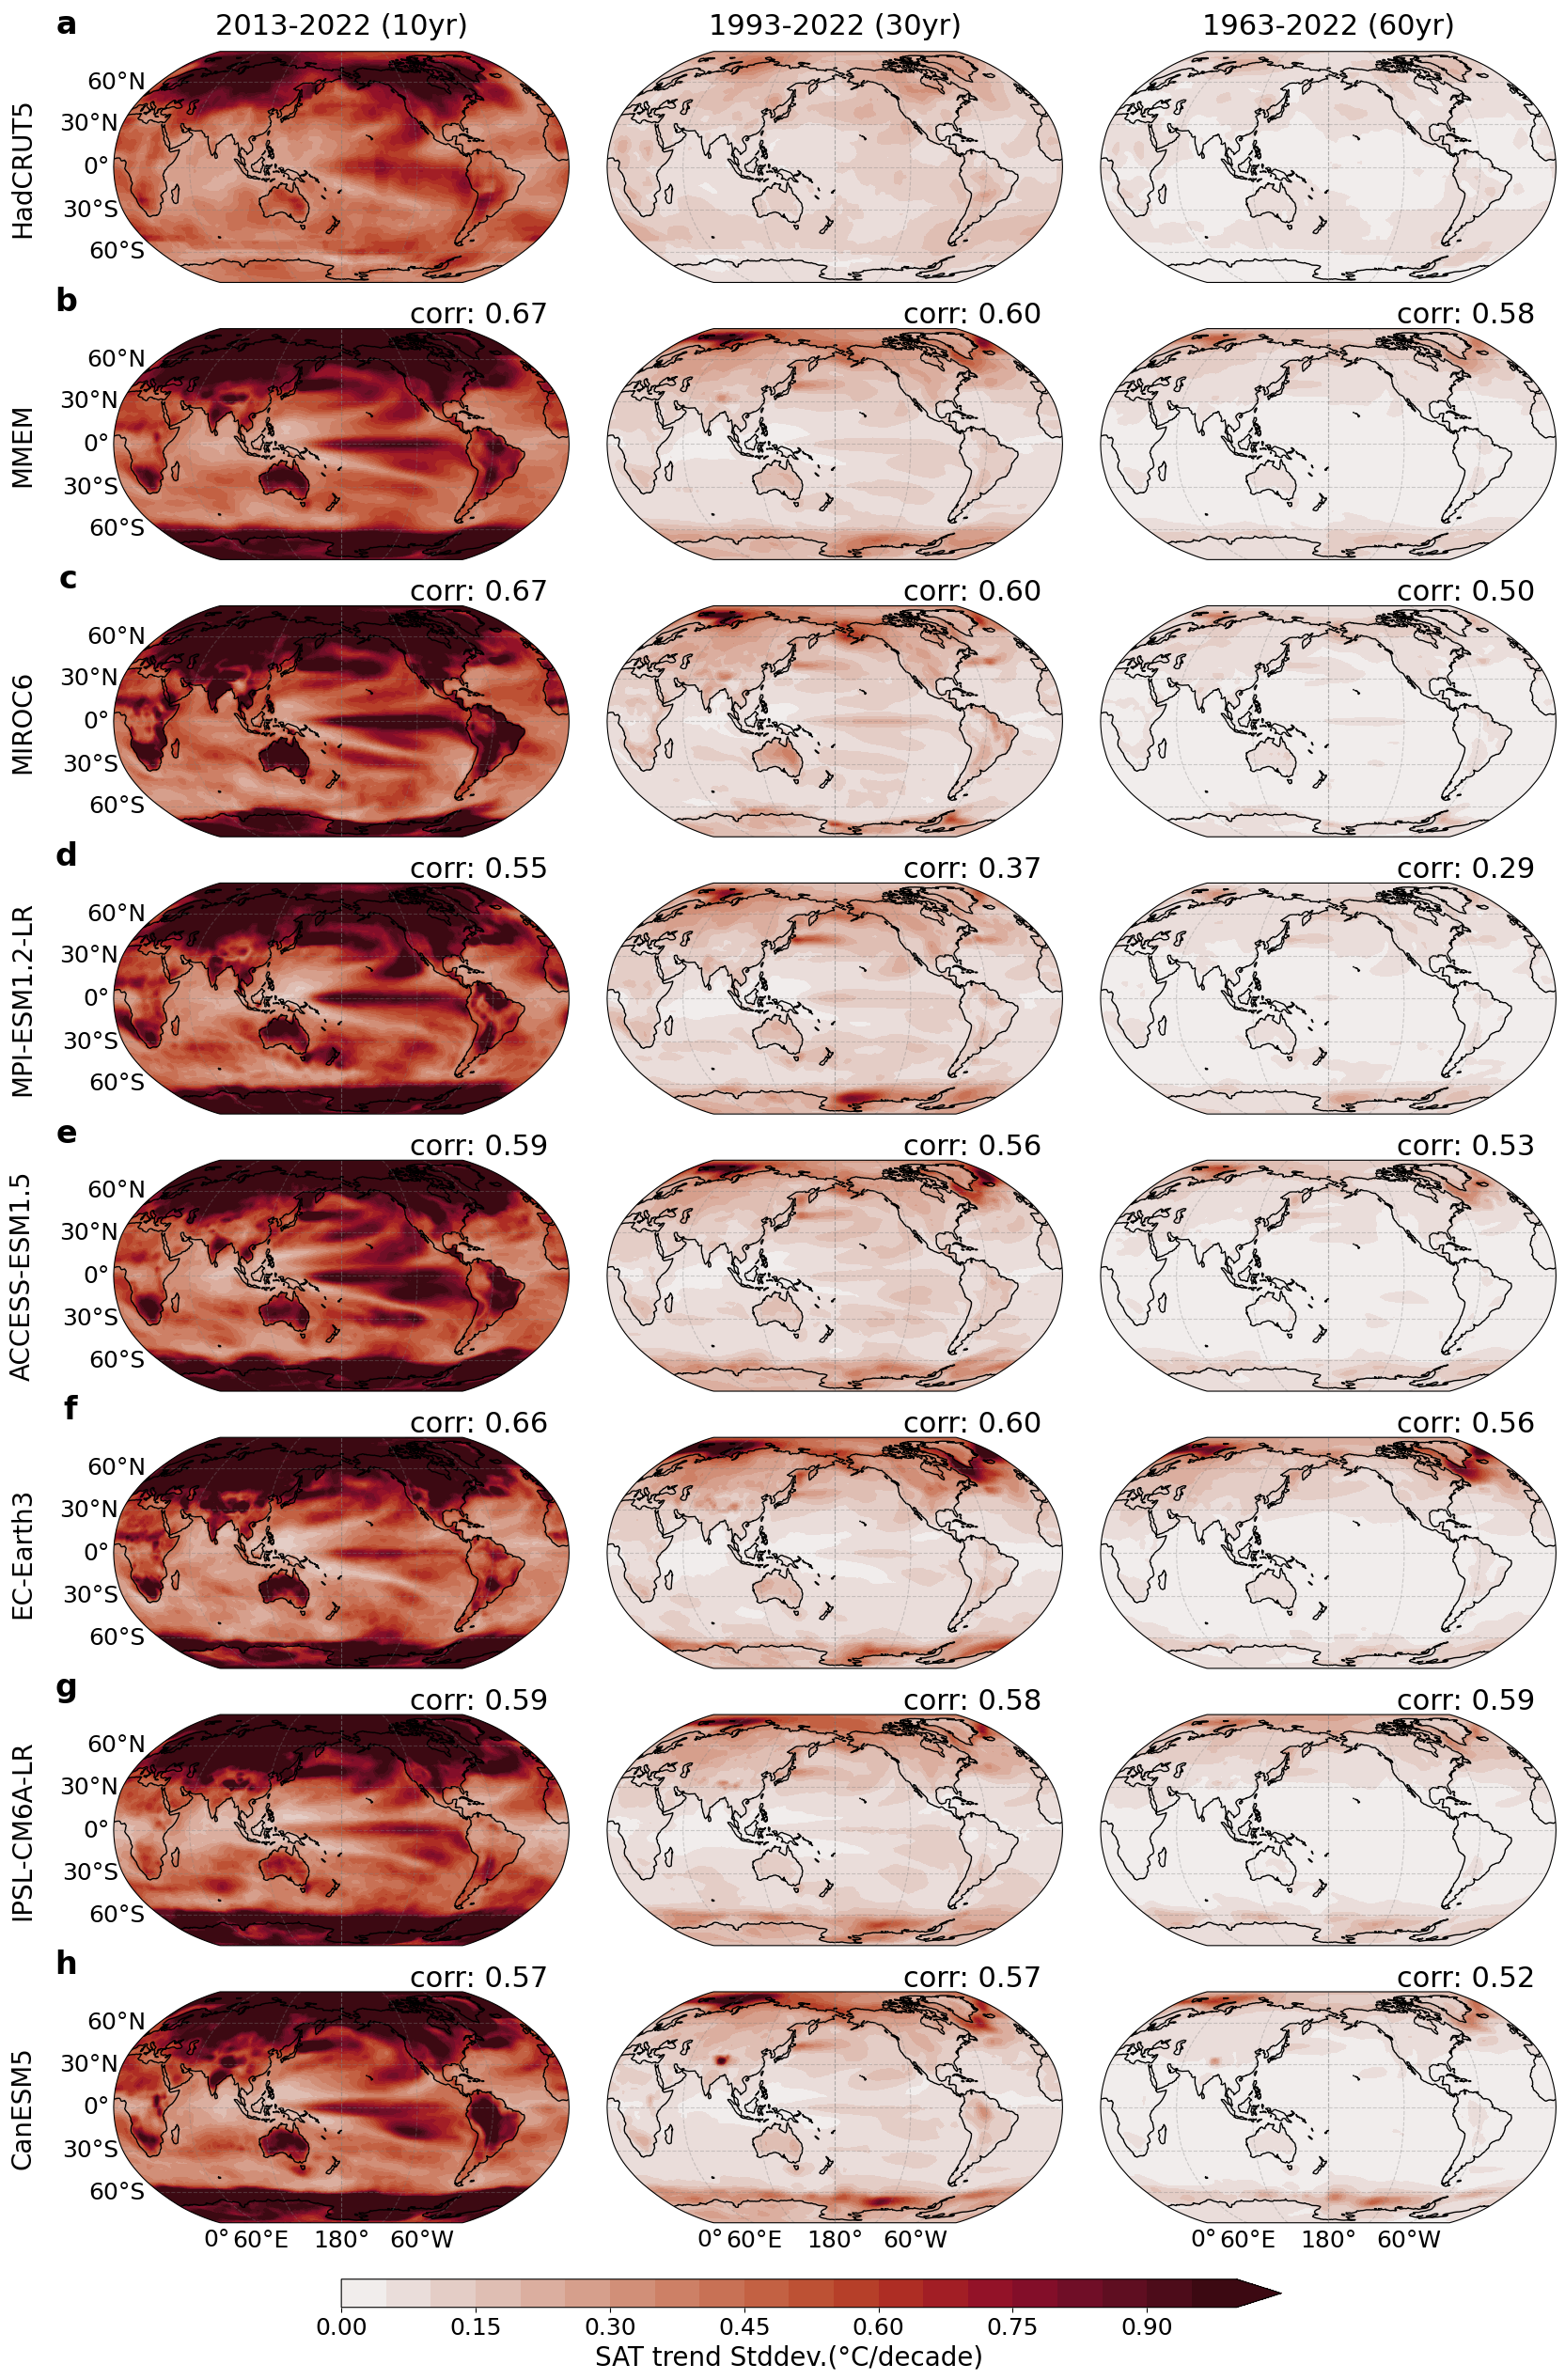

In [31]:
# Plotting
lat = trend_60yr['HadCRUT5'].lat
lon = trend_60yr['HadCRUT5'].lon
lat, lon 

titles_rows = ["HadCRUT5", "MMEM", "MIROC6", "MPI-ESM1.2-LR","ACCESS-ESM1.5", "EC-Earth3", "IPSL-CM6A-LR", "CanESM5"]
rows_label = ["a", "b", "c", "d", "e", "f", "g", "h"]
titles_columns = ["2013-2022 (10yr)", "1993-2022 (30yr)", "1963-2022 (60yr)"]

import cartopy.util as cutil
import seaborn as sns
import matplotlib.colors as mcolors
import palettable

periods = ["10yr", "30yr", "60yr"]
variable_name = ["HadCRUT5","MMEM", "MIROC6", "MPI_ESM", "ACCESS", "EC_Earth3", "IPSL", "CanESM5"]

intervals_obs = np.arange(-1.0, 1.1, 0.1)
intervals = np.arange(0.0, 1.05, 0.05)

cmap = mcolors.ListedColormap(palettable.cmocean.sequential.Amp_20.mpl_colors)
extend = 'both'

fig  = plt.figure(figsize=(20, 30))
gs = gridspec.GridSpec(8, 3, figure=fig,wspace=0.05, hspace=0.2)

# Create a 8x3 grid of subplots
axes = {}

# for i in range(0, 1):
#     # Add cyclic points
#     for j, period in enumerate(periods):
#         print(period)
#         is_left = j == 0
#         is_bottom_row = i >= 7
        
#         ax = plt.subplot(gs[i, j], projection=ccrs.Robinson(180))
#         ax.set_global()
#         axes[i, j] = ax
#         trend_data = obs_trend[period]
#         pval_data = p_val_data[period]
#         trend_with_cyclic, lons_cyclic = cutil.add_cyclic_point(trend_data, coord=lon)
#         p_value_with_cyclic, _ = cutil.add_cyclic_point(pval_data, coord=lon)
            
#         contour_obj = plot_trend_with_significance(trend_with_cyclic, lat, lons_cyclic,p_value_with_cyclic, levels=intervals_obs, extend = extend,
#                                             cmap='twilight_shifted', title=" ", ax=ax,
#                                             show_xticks = False, show_yticks = is_left)
for i in np.arange(0,8,1):
    for j, period in enumerate(periods):
        is_left = j == 0
        is_bottom_row = i >= 7
        
        ax = plt.subplot(gs[i, j], projection=ccrs.Robinson(180))
        ax.set_global()
        axes[i, j] = ax
                        
        if j == 0:
        # Add cyclic points
            trend_data = trend_10yr[variable_name[i]]['tas']
            trend_with_cyclic, lons_cyclic = cutil.add_cyclic_point(trend_data, coord=lon)
                    
            contour_obj1 = plot_trend(trend_with_cyclic, lat, lons_cyclic, 
                                            levels=intervals, extend = 'max',
                                            cmap=cmap, title=" ", ax=ax, 
                                            show_xticks = is_bottom_row, show_yticks = is_left)
        elif j == 1:
            trend_data = trend_30yr[variable_name[i]]['tas']
            trend_with_cyclic, lons_cyclic = cutil.add_cyclic_point(trend_data, coord=lon)
                    
            contour_obj2 = plot_trend(trend_with_cyclic, lat, lons_cyclic, 
                                            levels=intervals, extend = 'max',
                                            cmap=cmap, title=" ", ax=ax, 
                                            show_xticks = is_bottom_row, show_yticks = is_left)
        else:
            trend_data = trend_60yr[variable_name[i]]['tas']
            trend_with_cyclic, lons_cyclic = cutil.add_cyclic_point(trend_data, coord=lon)
                    
            contour_obj3 = plot_trend(trend_with_cyclic, lat, lons_cyclic,  
                                            levels=intervals, extend = 'max',
                                            cmap=cmap, title=" ", ax=ax, 
                                            show_xticks = is_bottom_row, show_yticks = is_left)

# add the title for each row
for i, var in enumerate(variable_name):
    axes[i, 0].text(-0.2, 0.5, titles_rows[i], va='center', ha='center', rotation=90, 
                    fontsize=20,transform=axes[i, 0].transAxes)
    axes[i, 0].text(-0.08, 1.05, rows_label[i], va='bottom', ha='right', rotation='horizontal',
                    fontsize=24, fontweight='bold', transform=axes[i, 0].transAxes)

# add the title for each column
for j in range(3):
    axes[0,j].text(0.5, 1.05, titles_columns[j], va='bottom', ha='center', rotation='horizontal', 
                   fontsize=22,transform=axes[0, j].transAxes)

# Add the pattern correlation text to the second to last rows of each column subplot
for i in np.arange(1,8,1):
    axes[i, 0].text(0.65, 1.0, f"corr: {trend_pattern_correlation_10yr[i]:.2f}", va='bottom', ha='left', fontsize=22,transform=axes[i, 0].transAxes)
    axes[i, 1].text(0.65, 1.0, f"corr: {trend_pattern_correlation_30yr[i]:.2f}", va='bottom', ha='left', fontsize=22,transform=axes[i, 1].transAxes)
    axes[i, 2].text(0.65, 1.0, f"corr: {trend_pattern_correlation_60yr[i]:.2f}", va='bottom', ha='left', fontsize=22,transform=axes[i, 2].transAxes)

# Add horizontal colorbars
# cbar_ax = fig.add_axes([0.2, 0.08, 0.3, 0.012])
# cbar = plt.colorbar(contour_obj, cax=cbar_ax, orientation='horizontal', extend=extend)
# cbar.ax.tick_params(labelsize=16)
# cbar.set_label('Annual SAT Trend (°C/decade)', fontsize=16)

cbar_ax1 = fig.add_axes([0.25, 0.08, 0.5, 0.01])
cbar1 = plt.colorbar(contour_obj1, cax=cbar_ax1, orientation='horizontal', extend='max')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('SAT trend Stddev.(°C/decade)', fontsize=20)

# plt.figure(constrained_layout=True)
fig.savefig('Extended-Fig-3-check.png', dpi=300, bbox_inches='tight')
fig.savefig('Extended-Fig-3-check.eps', format='eps', dpi=300, bbox_inches='tight')
fig.savefig('Extended-Fig-3-check.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()